# Cab-Driver Agent

## Problem Statement

`You are hired as a Sr. Machine Learning Er. at SuperCabs, a leading app-based cab provider in a large Indian metro city. In this highly competitive industry, retention of good cab drivers is a crucial business driver, and you believe that a sound RL-based system for assisting cab drivers can potentially retain and attract new cab drivers. `

 

`Cab drivers, like most people, are incentivised by a healthy growth in income. The goal of your project is to build an RL-based algorithm which can help cab drivers maximise their profits by improving their decision-making process on the field.`

In [1]:
# Importing libraries
import numpy as np
import random
import math
from collections import deque
import collections
import pickle

# for building DQN model
from keras import layers
from keras import Sequential
from keras.layers import Dense, Activation, Flatten
from keras.optimizers import Adam

# for plotting graphs
import matplotlib.pyplot as plt

# Import the environment
from Env import CabDriver
import time

Using TensorFlow backend.


#### Defining Time Matrix

In [2]:
# Loading the time matrix provided
Time_matrix = np.load('TM.npy')

In [3]:
# shape of time_matrix
print('Time-matrix Shape: ',Time_matrix.shape)
print('Time taken from location 2 to location 3 on 11 am on 5th day of the week: ',Time_matrix[2,3,11,5])

Time-matrix Shape:  (5, 5, 24, 7)
Time taken from location 2 to location 3 on 11 am on 5th day of the week:  2.0


In [4]:
state_action_temp_value_2=[]
for i in range(Time_matrix.shape[0]):
    for j in range(Time_matrix.shape[1]):
        for t in range(Time_matrix.shape[2]):
            for d in range(Time_matrix.shape[3]):
                if Time_matrix[i,j,t,d] == 2 and i!=j:
                    for k in range(1,Time_matrix.shape[0]+1):
                        state_action_temp_value_2.append(((k,t,d),(i+1,j+1)))
print('Number of actions with 2  time taken: ', len(state_action_temp_value_2[0:10]))
print(random.sample(state_action_temp_value_2,10))

Number of actions with 2  time taken:  10
[((4, 11, 3), (5, 1)), ((5, 15, 5), (4, 2)), ((4, 22, 5), (2, 5)), ((2, 15, 0), (1, 4)), ((4, 16, 6), (3, 2)), ((5, 17, 6), (2, 3)), ((2, 19, 1), (5, 3)), ((5, 13, 0), (3, 5)), ((3, 22, 3), (1, 2)), ((1, 12, 6), (3, 2))]


#### Tracking the state-action pairs for checking convergence


In [5]:
# Initialise Q_dictionary as 'Q_dict' and State_tracked as 'States_track' for convergence
Q_dict= collections.defaultdict(dict)
States_track = collections.defaultdict(dict)
#rewards_tracked = {(1,0,2):[],(2,6,3):[], (3,3,2): [], (5,11,6):[],(0,20,3):[],(1,20,3):[]} #select any 6 Q-values

In [6]:
# Initialise states to be tracked
def initialise_tracking_states():

    sample_q_values = [((1,0,2),(2,1)),((2,6,3),(1,3)),((3,3,2),(4,2)),((5,11,6),(3,4)),((0,20,3),(1,3)), ((1,20,3),(1,3))]    #select any 6 Q-values

    for q_values in sample_q_values:
        state = q_values[0]    
        action = q_values[1]
        States_track[state][action]=[]     #this is an array which will have appended values of that state-action pair for every 10th episode         
        

In [7]:
# Defining a function to save the Q-dictionary as pickle file
def save_obj(obj,name):
    with open(name+'.pkl','wb') as f:         # 'b' appended to the mode opens the file in binary mode
        pickle.dump(obj,f,pickle.HIGHEST_PROTOCOL)
        

In [8]:
# This function will append latest Q-values of the 6 Q-values which are being tracked for checking convergence
def save_tracking_states():
    for state in States_track.keys():
        for action in States_track[state].keys():
            Q= agent.prediction([action],state)
            States_track[state][action].append(Q)

In [9]:
initialise_tracking_states()

### Agent Class

If you are using this framework, you need to fill the following to complete the following code block:
1. State and Action Size
2. Hyperparameters
3. Create a neural-network model in function 'build_model()'
4. Define epsilon-greedy strategy in function 'get_action()'
5. Complete the function 'append_sample()'. This function appends the recent experience tuple <state, action, reward, new-state> to the memory
6. Complete the 'train_model()' function with following logic:
   - If the memory size is greater than mini-batch size, you randomly sample experiences from memory as per the mini-batch size and do the following:
      - Initialise your input and output batch for training the model
      - Calculate the target Q value for each sample: reward + gamma*max(Q(s'a,))
      - Get Q(s', a) values from the last trained model
      - Update the input batch as your encoded state and output batch as your Q-values
      - Then fit your DQN model using the updated input and output batch.

In [10]:
class DQNAgent:
    def __init__(self, state_size, action_size):
        # Define size of state and action
        self.state_size = state_size
        self.action_size = action_size
        self.action_space = env.action_space

        # Write here: Specify you hyper parameters for the DQN
        self.discount_factor = 0.95
        self.learning_rate =  0.01      
        self.epsilon_max = 1.0
        self.epsilon_decay = 0.0001
        self.epsilon_min = 0.0
        self.epsilon = self.epsilon_max
        self.time_step = 0 
        self.batch_size = 64        
        # create replay memory using deque
        self.memory = deque(maxlen=2000)         # replay buffer memory of size 2000

        # create main model and target model
        self.model = self.build_model()

    # approximate Q function using Neural Network
    def build_model(self):
        model = Sequential()
       
        # Hidden layers
        model.add(Dense(32,input_dim= self.state_size, activation= 'relu', kernel_initializer='he_uniform'))
        model.add(Dense(32,activation='relu',kernel_initializer='he_uniform'))
        model.add(Dense(1, activation='linear',kernel_initializer='he_uniform'))
        
        # Compile model
        model.compile(loss='mse',optimizer=Adam(lr=self.learning_rate))
        model.summary
        return model    
    
    
    def prediction(self, poss_actions,state):
        pred = np.zeros((len(poss_actions), 46))
        for i in range(len(poss_actions)):
            encoded_state = env.state_encod_arch2(state,poss_actions[i])    # encoded state of size (state_size + action_size)
            pred[i,:]= encoded_state 
        prediction = self.model.predict(pred).reshape(len(poss_actions))    # predicted Q value from NN model 
        return prediction
    
    
    
    def get_action(self, state):
    # get action from model using epsilon-greedy policy 
        if np.random.rand()<=self.epsilon:                   # Exploration: randomly choosing and action    
            # select random action 
            actions = env.requests(state)
            action = random.choice(actions)
        else:                                                # Exploitation: this gets the action corresponding to max q-value of current state
            poss_actions = env.requests(state)
            q_value= self.prediction(poss_actions,state)     #  Q value from prediction method 
            action_index = np.argmax(q_value)                # index of max q value
            action = poss_actions[action_index]
        return action

    
    def decay_epsilon(self):
    # Decay in ε after we generate each sample from the environment
        self.time_step += 1 
        self.epsilon = self.epsilon_min + (self.epsilon_max - self.epsilon_min) * np.exp(- self.epsilon_decay * self.time_step)       


    def append_sample(self, state, action, reward, next_state, done):
    # save sample <s,a,r,s'> to the replay memory
        self.memory.append((state,action,reward,next_state, done))
    
    
    # pick samples randomly from replay memory (with batch_size) and train the network
    def train_model(self):
        
        if len(self.memory) > self.batch_size:
            # Sample batch from the memory
            mini_batch = random.sample(self.memory, self.batch_size)
            update_output = np.zeros((self.batch_size,self.action_size))
            update_input = np.zeros((self.batch_size, self.state_size))
            
            actions, rewards , terminal = [], [], []           # initialise actions, rewards
            
            for i in range(self.batch_size):
                state, action, reward, next_state, done = mini_batch[i]
                actions.append(self.action_space.index(action))
                rewards.append(reward)
                terminal.append(done)
                
                update_input[i]=env.state_encod_arch2(state,action)
                update_output[i,:]=self.prediction(self.action_space, next_state)
            
            target = np.zeros((self.batch_size))
            for i in range(self.batch_size):
                if terminal[i]:                           # terminal state reached 
                    target[i]= rewards[i]
                else:                                 
                    target[i] = rewards[i] + self.discount_factor * (np.amax(update_output[i]))
            
            self.model.fit(update_input, target, batch_size=self.batch_size, epochs=1, verbose=0)   
   
    def load(self, name):                            # load model weights 
        self.model.load_weights(name)

    def save(self, name):                            # save model
        self.model.save(name)

In [11]:
Episodes = 13000

### DQN block

In [12]:
env= CabDriver()
state_size = 46             # get size of state  m+t+d+m+m = 5+24+7+5+5= 46  
action_size = len(env.action_space)    # get size of action from environment
agent = DQNAgent(state_size,action_size)
avg_reward = []                        # tracking average reward per episode
total_rewards  = []                     # tracking total rewards per episode



start_time = time.time()      # start time
for episode in range(Episodes):
    
    total_reward= 0
    done=False
    state= env.reset()
    time_step = 0
    
    while not done:
        # Pick epsilon-greedy action from possible actions for the current state
        action = agent.get_action(state) 
        # Evaluate your reward and next state
        reward = env.reward_func(state,action,Time_matrix)      
        next_state, done = env.next_state_func(state, action, Time_matrix)
        agent.append_sample(state, action,reward,next_state,done)       # Append the experience to the memory
        agent.decay_epsilon()
        # Train the model every timestep by calling function agent.train_model 
        agent.train_model()
        total_reward+=reward
        state= next_state
        time_step +=1
        
        
        # Keep a track of rewards, Q-values, loss
        if done and episode%20 == 0:   
            avg_reward.append(total_reward/time_step)
            total_rewards.append(total_reward)
            print("episode:", episode, "  score:", total_reward, "  memory length:",\
                  len(agent.memory), "  epsilon:", agent.epsilon,"   timestep:", time_step)
            
            
    if episode % 100 == 0:
        agent.save("./cab_driver.h5")
        
    if episode % 10 == 0:   #every 10th episode
        save_obj(avg_reward,'Rewards')   
        save_tracking_states()
        save_obj(States_track,'States_tracked') 
        
elapsed_time = time.time() - start_time
print(elapsed_time)
            
        

episode: 0   score: -353.0   memory length: 144   epsilon: 0.985703184122443    timestep: 144
episode: 50   score: 441.0   memory length: 2000   epsilon: 0.4749242316436967    timestep: 146
episode: 100   score: 985.0   memory length: 2000   epsilon: 0.22786543992898983    timestep: 148
episode: 150   score: 1161.0   memory length: 2000   epsilon: 0.11148112331920754    timestep: 141
episode: 200   score: 1325.0   memory length: 2000   epsilon: 0.052786489589461846    timestep: 150
episode: 250   score: 1026.0   memory length: 2000   epsilon: 0.024076957889856084    timestep: 138
episode: 300   score: 1323.0   memory length: 2000   epsilon: 0.010961128910322906    timestep: 165
episode: 350   score: 1416.0   memory length: 2000   epsilon: 0.004778158775953219    timestep: 145
episode: 400   score: 1269.0   memory length: 2000   epsilon: 0.0021700610026600302    timestep: 186
episode: 450   score: 1323.0   memory length: 2000   epsilon: 0.0009042542383491043    timestep: 166
episode: 50

episode: 4050   score: 1183.0   memory length: 2000   epsilon: 1.2045524278836245e-33    timestep: 229
episode: 4100   score: 1206.0   memory length: 2000   epsilon: 4.414493751006221e-34    timestep: 205
episode: 4150   score: 1431.0   memory length: 2000   epsilon: 1.6225405503535661e-34    timestep: 183
episode: 4200   score: 1726.0   memory length: 2000   epsilon: 5.793741335219074e-35    timestep: 183
episode: 4250   score: 1449.0   memory length: 2000   epsilon: 2.1273525126139702e-35    timestep: 191
episode: 4300   score: 1404.0   memory length: 2000   epsilon: 7.988982043030975e-36    timestep: 164
episode: 4350   score: 1456.0   memory length: 2000   epsilon: 2.9010227516063494e-36    timestep: 194
episode: 4400   score: 1332.0   memory length: 2000   epsilon: 1.0689355580714145e-36    timestep: 208
episode: 4450   score: 1555.0   memory length: 2000   epsilon: 4.067987643848606e-37    timestep: 185
episode: 4500   score: 1416.0   memory length: 2000   epsilon: 1.598472428129

episode: 8100   score: 1534.0   memory length: 2000   epsilon: 9.328612813639248e-68    timestep: 178
episode: 8150   score: 1719.0   memory length: 2000   epsilon: 3.5926364623536902e-68    timestep: 173
episode: 8200   score: 1386.0   memory length: 2000   epsilon: 1.4337398693499018e-68    timestep: 207
episode: 8250   score: 1569.0   memory length: 2000   epsilon: 5.5028790371984e-69    timestep: 194
episode: 8300   score: 1700.0   memory length: 2000   epsilon: 2.2575302739104345e-69    timestep: 174
episode: 8350   score: 1269.0   memory length: 2000   epsilon: 9.312489997239742e-70    timestep: 206
episode: 8400   score: 1458.0   memory length: 2000   epsilon: 3.5957640848727396e-70    timestep: 196
episode: 8450   score: 1458.0   memory length: 2000   epsilon: 1.427259981823161e-70    timestep: 196
episode: 8500   score: 1605.0   memory length: 2000   epsilon: 5.72384969478796e-71    timestep: 209
episode: 8550   score: 1690.0   memory length: 2000   epsilon: 2.1600721039067507

episode: 12100   score: 1617.0   memory length: 2000   epsilon: 2.8483478186178055e-98    timestep: 172
episode: 12150   score: 1629.0   memory length: 2000   epsilon: 1.211839088315133e-98    timestep: 191
episode: 12200   score: 1566.0   memory length: 2000   epsilon: 5.1060402741996295e-99    timestep: 162
episode: 12250   score: 1717.0   memory length: 2000   epsilon: 2.18458134574353e-99    timestep: 187
episode: 12300   score: 1692.0   memory length: 2000   epsilon: 9.155999059809172e-100    timestep: 187
episode: 12350   score: 1575.0   memory length: 2000   epsilon: 3.793197380330165e-100    timestep: 175
episode: 12400   score: 1411.0   memory length: 2000   epsilon: 1.5084902246312195e-100    timestep: 191
episode: 12450   score: 1570.0   memory length: 2000   epsilon: 6.27638634693581e-101    timestep: 164
episode: 12500   score: 1539.0   memory length: 2000   epsilon: 2.5911308250137794e-101    timestep: 177
episode: 12550   score: 1269.0   memory length: 2000   epsilon: 1.

### Tracking Convergence

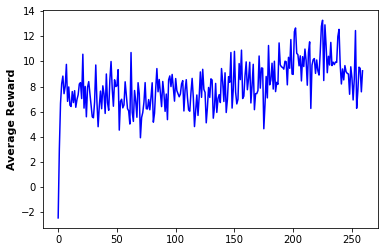

In [22]:
# Plotting average rewards
# x-values = 260 episodes tracked after every 25th episode
plt.plot(list(range(len(avg_reward))), avg_reward,c='b')
plt.ylabel("Average Reward",fontsize=11.0, fontweight='bold')
plt.show()


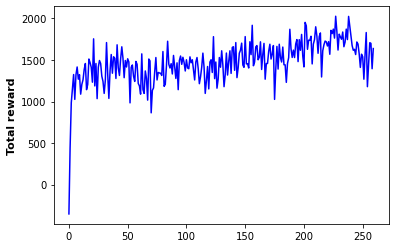

In [23]:
# Plotting total rewards
plt.plot(list(range(len(total_rewards))), total_rewards,c='b')
plt.ylabel("Total reward",fontsize=11.0, fontweight='bold')
plt.show()

## Checking Q-values for convergence

<function matplotlib.pyplot.show(close=None, block=None)>

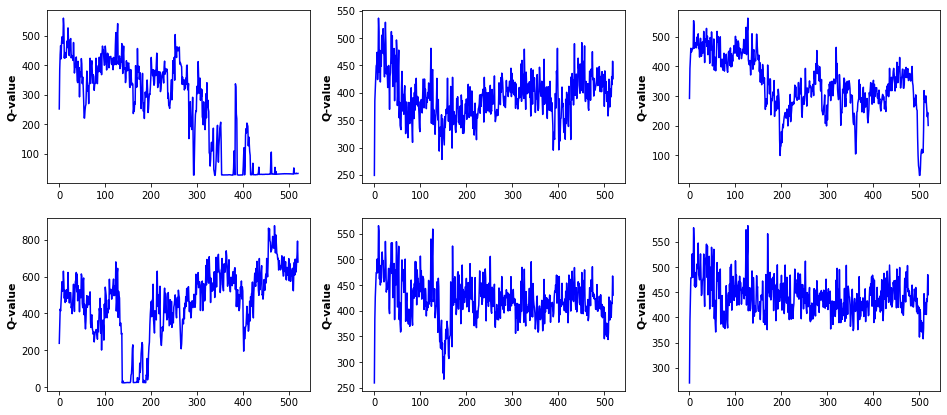

In [27]:
plt.figure(0, figsize=(16,7))

xaxis = np.asarray(range(len(States_track[(1,0,2)][(2,1)])))
plt.subplot(231)
plt.plot(xaxis,np.asarray(States_track[(1,0,2)][(2,1)]),c='b')
plt.ylabel("Q-value",fontsize=11.0, fontweight='bold')
plt.show

xaxis = np.asarray(range(len(States_track[(2,6,3)][(1,3)])))
plt.subplot(232)
plt.plot(xaxis,np.asarray(States_track[(2,6,3)][(1,3)]),c='b')
plt.ylabel("Q-value",fontsize=11.0, fontweight='bold')
plt.show

xaxis = np.asarray(range(len(States_track[(3,3,2)][(4,2)])))
plt.subplot(233)
plt.plot(xaxis,np.asarray(States_track[(3,3,2)][(4,2)]),c='b')
plt.ylabel("Q-value",fontsize=11.0, fontweight='bold')
plt.show

xaxis = np.asarray(range(len(States_track[(5,11,6)][(3,4)])))
plt.subplot(234)
plt.plot(xaxis,np.asarray(States_track[(5,11,6)][(3,4)]),c='b')
plt.ylabel("Q-value",fontsize=11.0, fontweight='bold')
plt.show

xaxis = np.asarray(range(len(States_track[(0,20,3)][(1,3)])))
plt.subplot(235)
plt.plot(xaxis,np.asarray(States_track[(0,20,3)][(1,3)]),c='b')
plt.ylabel("Q-value",fontsize=11.0, fontweight='bold')
plt.show

xaxis = np.asarray(range(len(States_track[(1,20,3)][(1,3)])))
plt.subplot(236)
plt.plot(xaxis,np.asarray(States_track[(1,20,3)][(1,3)]),c='b')
plt.ylabel("Q-value",fontsize=11.0, fontweight='bold')
plt.show


## Zoomed Last 300 Q values 

<function matplotlib.pyplot.show(close=None, block=None)>

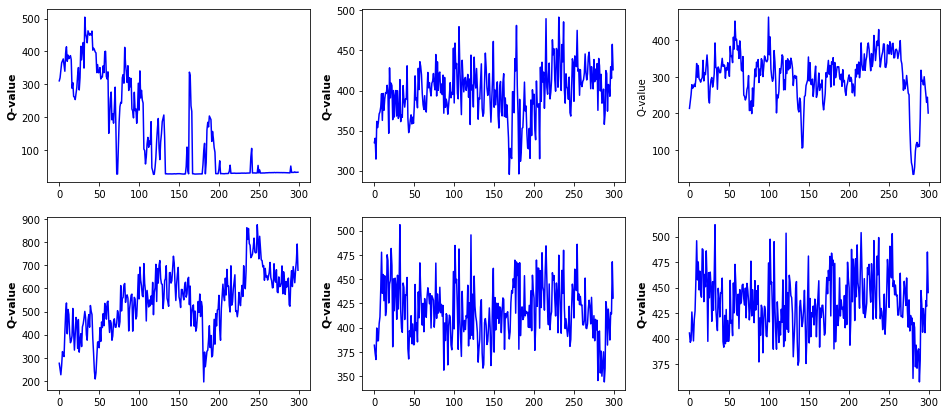

In [33]:
plt.figure(0, figsize=(16,7))

xaxis = np.asarray(range(300))
plt.subplot(231)
plt.plot(xaxis,np.asarray(States_track[(1,0,2)][(2,1)])[-300:],c='b')
plt.ylabel("Q-value",fontsize=11.0, fontweight='bold')
plt.show

xaxis = np.asarray(range(300))
plt.subplot(232)
plt.plot(xaxis,np.asarray(States_track[(2,6,3)][(1,3)])[-300:],c='b')
plt.ylabel("Q-value",fontsize=11.0, fontweight='bold')
plt.show

xaxis = np.asarray(range(300))
plt.subplot(233)
plt.plot(xaxis,np.asarray(States_track[(3,3,2)][(4,2)])[-300:],c='b')
plt.ylabel("Q-value")
plt.show

xaxis = np.asarray(range(300))
plt.subplot(234)
plt.plot(xaxis,np.asarray(States_track[(5,11,6)][(3,4)])[-300:],c='b')
plt.ylabel("Q-value",fontsize=11.0, fontweight='bold')
plt.show

xaxis = np.asarray(range(300))
plt.subplot(235)
plt.plot(xaxis,np.asarray(States_track[(0,20,3)][(1,3)])[-300:],c='b')
plt.ylabel("Q-value",fontsize=11.0, fontweight='bold')
plt.show

xaxis = np.asarray(range(300))
plt.subplot(236)
plt.plot(xaxis,np.asarray(States_track[(1,20,3)][(1,3)])[-300:],c='b')
plt.ylabel("Q-value",fontsize=11.0, fontweight='bold')
plt.show

#### Epsilon-decay sample function

<div class="alert alert-block alert-info">
Try building a similar epsilon-decay function for your model.
</div>

In [34]:
time = np.arange(0,10000)
epsilon = []
for i in range(0,10000):
    epsilon.append(0 + (1 - 0) * np.exp(-0.0009*i))

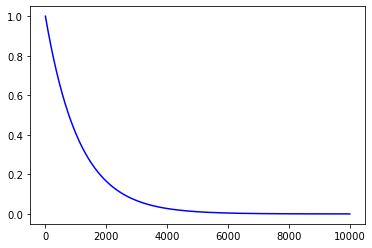

In [36]:
plt.plot(time, epsilon,c='b')
plt.show()